In [2]:
import itertools
import math
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x).reshape(-1)

class Deflatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(-1, 32, 25, 25)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Flatten(start_dim=0, end_dim=-1),
            nn.Linear(64 * 12 * 12, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 32 * 25 * 25),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            Deflatten(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()    
        )

    def forward(self, x):
        return self.model(x)

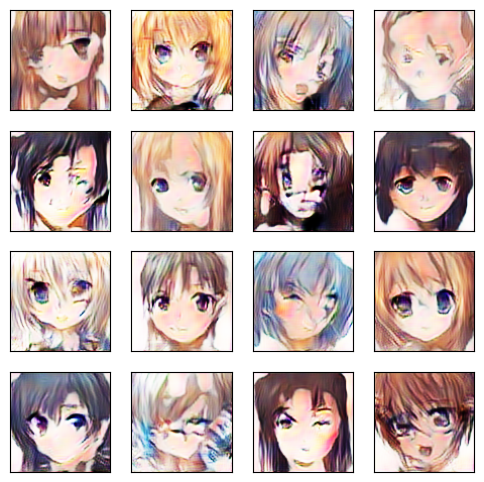

In [12]:
once_generate_num = 2000
select_num = 16
discriminator = Discriminator().cuda()
generator = Generator().cuda()
generator.load_state_dict(torch.load('../weight/generator_endl.pth'))
discriminator.load_state_dict(torch.load('../weight/discriminator_endl.pth'))
images = torch.zeros(once_generate_num,3,100,100).cuda()
for i in range(once_generate_num):
  noise = torch.randn(3, 100, 100).cuda()
  images[i,:] = generator(noise)
scores = discriminator(images)
values,indices = torch.topk(scores, 16)
size_figure_grid = int(math.sqrt(select_num))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
for k in range(select_num):
  i = k // 4
  j = k % 4
  ax[i, j].cla()
  ax[i, j].imshow(images[indices[k], :].data.cpu().permute(1,2,0))
display.clear_output(wait=True)
plt.savefig('../output/saved_image.png', dpi=300, bbox_inches='tight')
del images
del scores
del values
del indices
torch.cuda.empty_cache()
#display.display(plt.gcf())